### Simple Language Modeling (based on Andrej Karpathy Youtube tutorials)

The dataset is a large collection of people's first names. We will train character level language models on next character prediction task and use it to generate new names.

In [3]:
# load dataset and store the words in a list
words = open('names.txt', 'r').read().split()

In [6]:
print(f"Total number of words: {len(words)}")
print(f"Shortest word: {min([len(w) for w in words])}")
print(f"Longest word: {max([len(w) for w in words])}")

Total number of words: 32033
Shortest word: 2
Longest word: 15


### Bi-Gram Language Model. 

This model predicts the next character given the previous two characters in a sequence, i.e. the conditional probability distribution $p(c2 | c1)$ for a sequence {c1,c2} where c1 is known/given. It calculates this probability distribution as follows:

$p(c2|c1) = \frac{\text{count}(c1, c2)}{\text{count}(c1)}$ 

where $count(c1,c2)$ is the number of times the sequence {c1,c2} has been observed in the corpus. Similarly $count(c1)$ is the number of times the sequence {c1} has been observed.



In [64]:
# first lets count all possible bigrams and unigrams in the corpus
unigrams = {}
bigrams = {}
special_token = '*'  # this special token will be used as the start and end of each word  
for w in words:
    # wrap the word with start and end special characters
    chars = [special_token] + list(w) + [special_token]

    # count unigrams
    for c in chars:
        unigrams[c] = unigrams.get(c, 0) + 1

    # count bigrams
    for c1, c2 in zip(chars, chars[1:]):
        bigram = (c1,c2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1    
        


In [65]:
# sort the dictionary item tuples by value
sorted(unigrams.items(), key = lambda key_value : key_value[1])

[('q', 272),
 ('x', 697),
 ('f', 905),
 ('w', 929),
 ('p', 1026),
 ('g', 1927),
 ('z', 2398),
 ('v', 2573),
 ('b', 2645),
 ('j', 2900),
 ('u', 3135),
 ('c', 3532),
 ('k', 5040),
 ('d', 5496),
 ('t', 5570),
 ('m', 6642),
 ('h', 7616),
 ('o', 7934),
 ('s', 8106),
 ('y', 9776),
 ('r', 12700),
 ('l', 13958),
 ('i', 17701),
 ('n', 18327),
 ('e', 20423),
 ('a', 33885),
 ('*', 64066)]

In [66]:
sorted(bigrams.items(), key = lambda key_value : key_value[1])

[(('q', 'r'), 1),
 (('d', 'z'), 1),
 (('p', 'j'), 1),
 (('q', 'l'), 1),
 (('p', 'f'), 1),
 (('q', 'e'), 1),
 (('b', 'c'), 1),
 (('c', 'd'), 1),
 (('m', 'f'), 1),
 (('p', 'n'), 1),
 (('w', 'b'), 1),
 (('p', 'c'), 1),
 (('h', 'p'), 1),
 (('f', 'h'), 1),
 (('b', 'j'), 1),
 (('f', 'g'), 1),
 (('z', 'g'), 1),
 (('c', 'p'), 1),
 (('p', 'k'), 1),
 (('p', 'm'), 1),
 (('x', 'n'), 1),
 (('s', 'q'), 1),
 (('k', 'f'), 1),
 (('m', 'k'), 1),
 (('x', 'h'), 1),
 (('g', 'f'), 1),
 (('v', 'b'), 1),
 (('j', 'p'), 1),
 (('g', 'z'), 1),
 (('v', 'd'), 1),
 (('d', 'b'), 1),
 (('v', 'h'), 1),
 (('h', 'h'), 1),
 (('g', 'v'), 1),
 (('d', 'q'), 1),
 (('x', 'b'), 1),
 (('w', 'z'), 1),
 (('h', 'q'), 1),
 (('j', 'b'), 1),
 (('x', 'm'), 1),
 (('w', 'g'), 1),
 (('t', 'b'), 1),
 (('z', 'x'), 1),
 (('p', 'b'), 2),
 (('t', 'g'), 2),
 (('q', 's'), 2),
 (('t', 'x'), 2),
 (('f', 'k'), 2),
 (('b', 't'), 2),
 (('j', 'n'), 2),
 (('k', 'c'), 2),
 (('z', 'k'), 2),
 (('s', 'j'), 2),
 (('s', 'f'), 2),
 (('z', 'j'), 2),
 (('n', 'q

In [67]:
import torch

In [68]:
# now lets create an indexed vocabulary of characters
vocab = sorted(set(unigrams.keys()))
ctoi = {vocab[i]:i for i in range(len(vocab))}
itoc = {i:vocab[i] for i in range(len(vocab))}
print(f"Vocabulary: {vocab}")
print(f"Character indices: {ctoi}")


Vocabulary: ['*', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Character indices: {'*': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [69]:
# instead of storing the counts in a dictionary, lets put them in pytorch tensors
ug_counts = torch.zeros(len(vocab), dtype=torch.int32)
bg_counts = torch.zeros((len(vocab),len(vocab)), dtype=torch.int32)

for w in words:
    # wrap the word with start and end special characters
    chars = [special_token] + list(w) + [special_token]

    # count unigrams
    for c in chars:
        ix = ctoi[c]
        ug_counts[ix] += 1

    # count bigrams
    for c1, c2 in zip(chars, chars[1:]):
        bigram = (c1,c2)
        ix1, ix2 = ctoi[c1], ctoi[c2]  
        bg_counts[ix1, ix2] += 1  


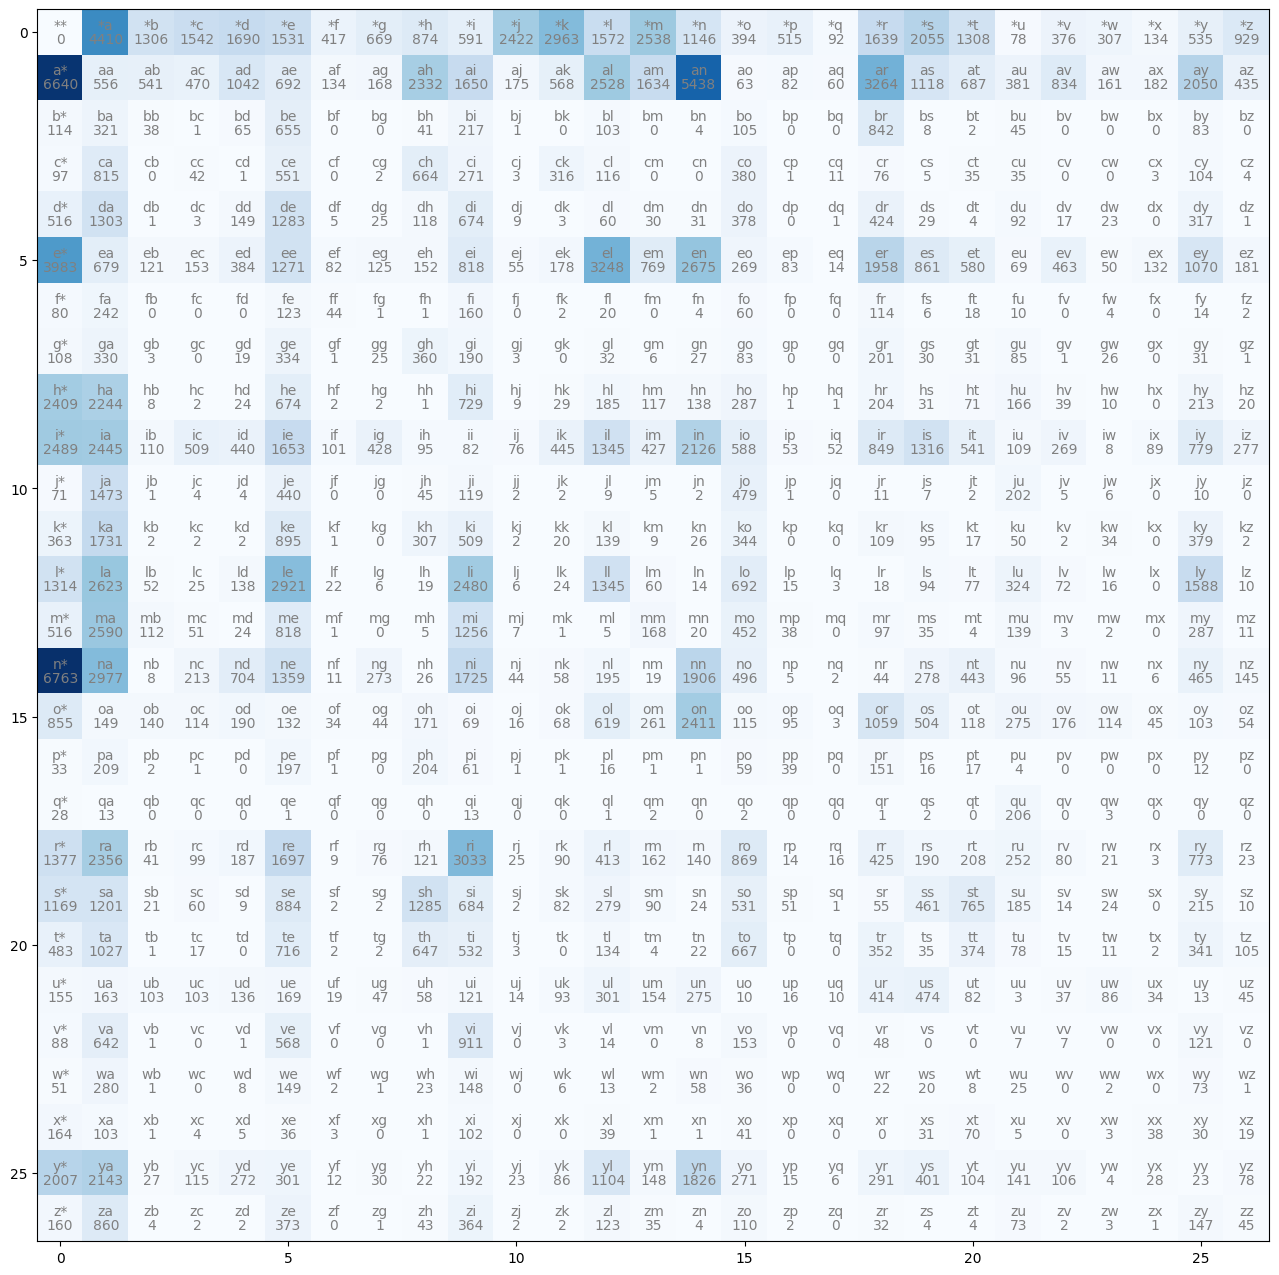

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(bg_counts, cmap='Blues')
for i in range(len(vocab)):
    for j in range(len(vocab)):
        bgstr = itoc[i] + itoc[j]
        plt.text(j,i, bgstr, ha='center', va='bottom', color='gray')
        plt.text(j,i, bg_counts[i,j].item(), ha='center', va='top', color='gray')


In [108]:
# we can divide each row in our bigram counts array by the sum of all entries in thar row to get the desired bigram language model probability distribution: p(c2|c1) 
row_sum = torch.sum(bg_counts, axis=1).reshape(len(vocab),-1)
p = bg_counts.float() / row_sum.float()

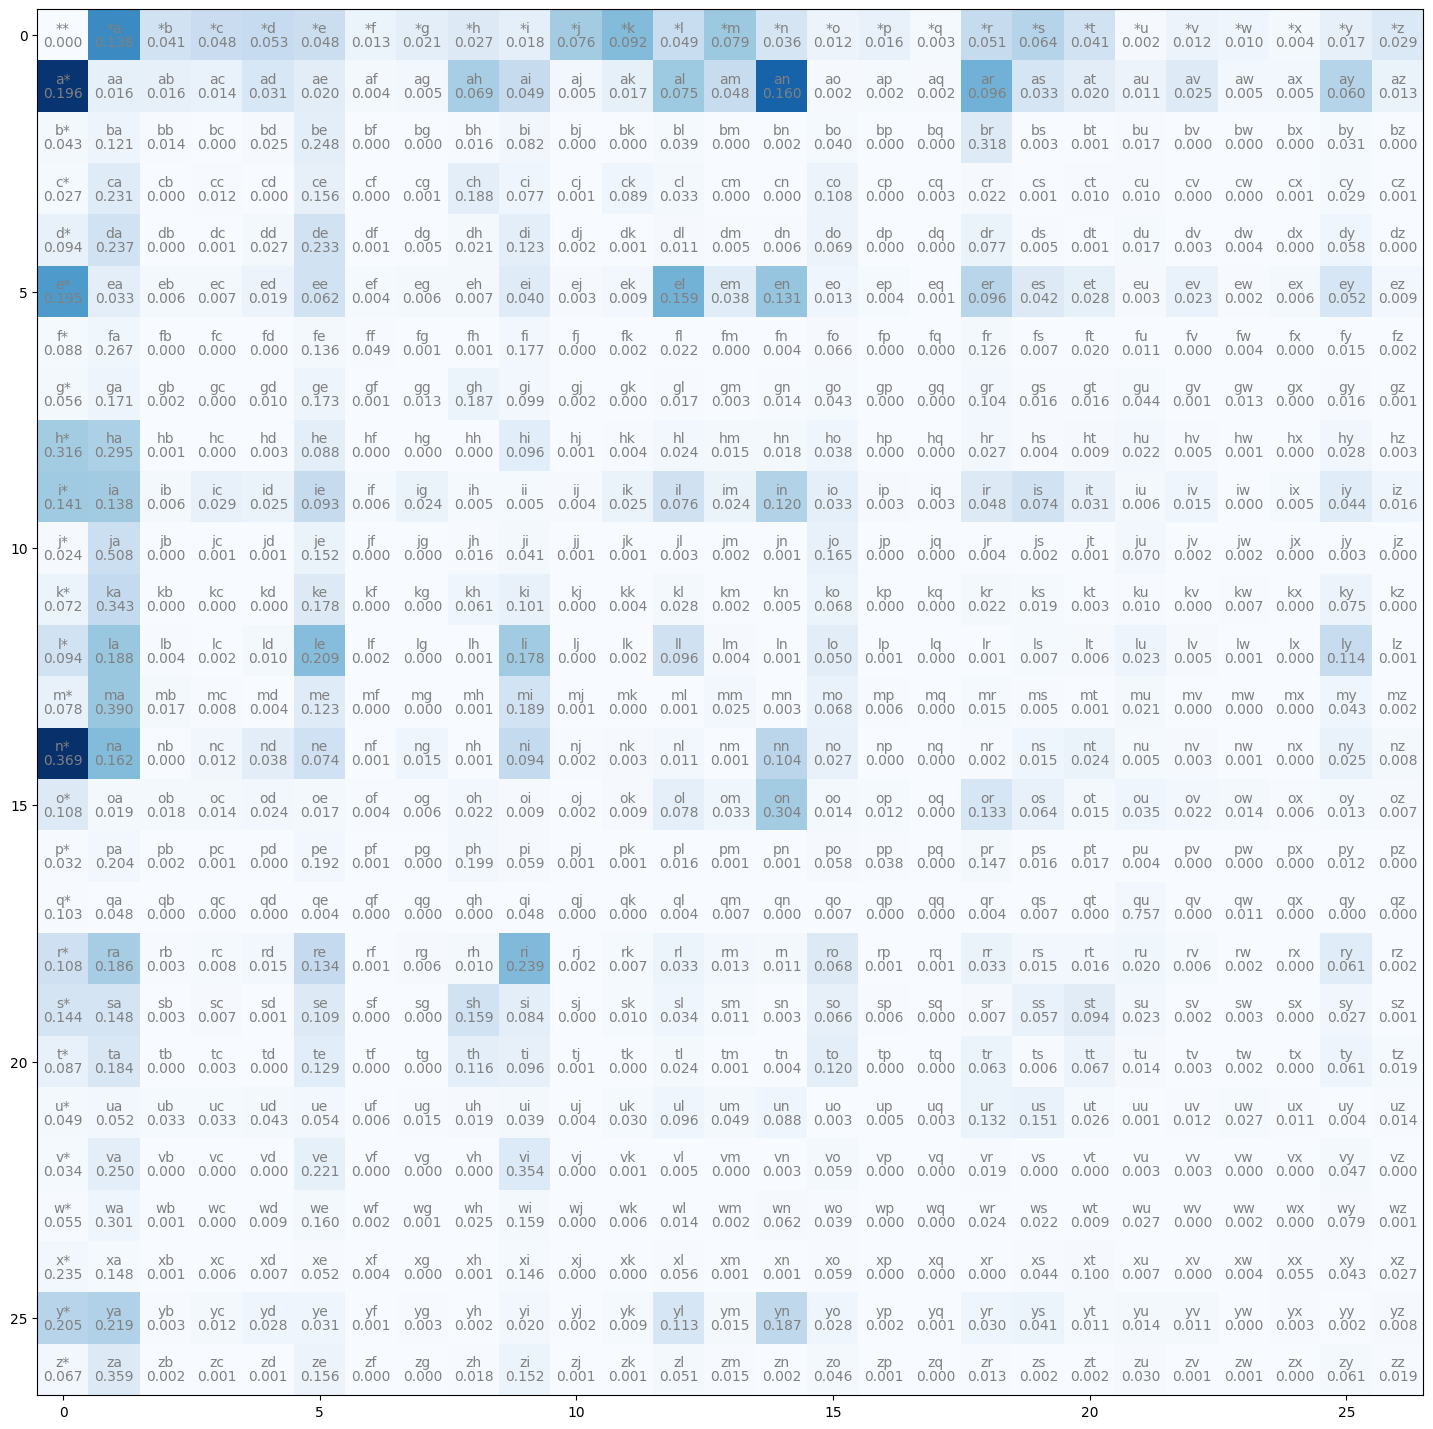

In [109]:
plt.figure(figsize=(18,18))
plt.imshow(bg_counts, cmap='Blues')
for i in range(len(vocab)):
    for j in range(len(vocab)):
        bgstr = itoc[i] + itoc[j]
        plt.text(j,i, bgstr, ha='center', va='bottom', color='gray')
        plt.text(j,i, f"{p[i,j].item():0.3f}", ha='center', va='top', color='gray')


### Now that we have the bi-gram  language model probabilty distribution, we can start generating new character sequences by sampling from this distribution  

In [128]:
# create a pytorch generator
g = torch.Generator().manual_seed(123)

def generate_word(start_char=None):

    generated_word = []
    end_ix = ctoi[special_token]

    # start with the special token
    if start_char is None:
        c1_ix = end_ix
    else:
        c1_ix = ctoi[start_char]
        generated_word.append(start_char)

    # generate characters one by one by sampling from the probability distribution p(c2|c1)
    while True:
        p21 = p[c1_ix]
        # sample the next character 
        c2_ix = torch.multinomial(p21, num_samples=1, replacement=True, generator=g).item()

        # stop if we generate the special token
        if c2_ix==end_ix:
            break
        
        c1_ix = c2_ix

        generated_word.append(itoc[c2_ix])

    return ''.join(generated_word) 

In [134]:
generate_word('r')

'ronana'